In [14]:
import pymc as pm
import arviz as az
import scipy.stats as ss
import numpy as np
import pandas as pd

### Task 1

In [54]:
data = ss.norm.rvs(size=1000, random_state=1337)
data = data[(data > -1) & (data < 2)]

In [55]:
with pm.Model() as model:
    mu = pm.Flat("mu")
    sigma = pm.HalfFlat("sigma")
    pm.Potential("log_prior", -pm.math.log(sigma))

    L = pm.Exponential("L", lam=1)
    U = pm.Exponential("U", lam=1)
    lower = pm.Deterministic("lower", data.min() - L)
    upper = pm.Deterministic("upper", data.max() + U)

    y = pm.Truncated("y", pm.Normal.dist(mu=mu, sigma=sigma), lower=lower, upper=upper, observed=data)

    trace = pm.sample(10000, chains=1, tune=1000)

Output()

In [56]:
pm.summary(trace)

Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L,0.004,0.004,0.000,0.012,0.000,0.000,5852.0,3786.0,NaN
U,0.016,0.017,0.000,0.045,0.000,0.000,5217.0,3713.0,NaN
lower,-0.990,0.004,-0.997,-0.986,0.000,0.000,5852.0,3786.0,NaN
mu,0.015,0.071,-0.119,0.140,0.001,0.001,5362.0,4386.0,NaN
sigma,1.022,0.073,0.894,1.162,0.001,0.001,4984.0,4365.0,NaN
upper,1.939,0.017,1.924,1.968,0.000,0.000,5217.0,3713.0,NaN


In [57]:
sigma_hdi = az.hdi(trace, var_names=["sigma"], hdi_prob=0.95)["sigma"]
print(f"95% дверительный интервал для сигмы: {sigma_hdi[0]:.8f}, {sigma_hdi[1]:.8f}")

95% дверительный интервал для сигмы: 0.89089383, 1.17050792


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'lower'}>,
        <Axes: title={'center': 'lower'}>],
       [<Axes: title={'center': 'upper'}>,
        <Axes: title={'center': 'upper'}>]], dtype=object)

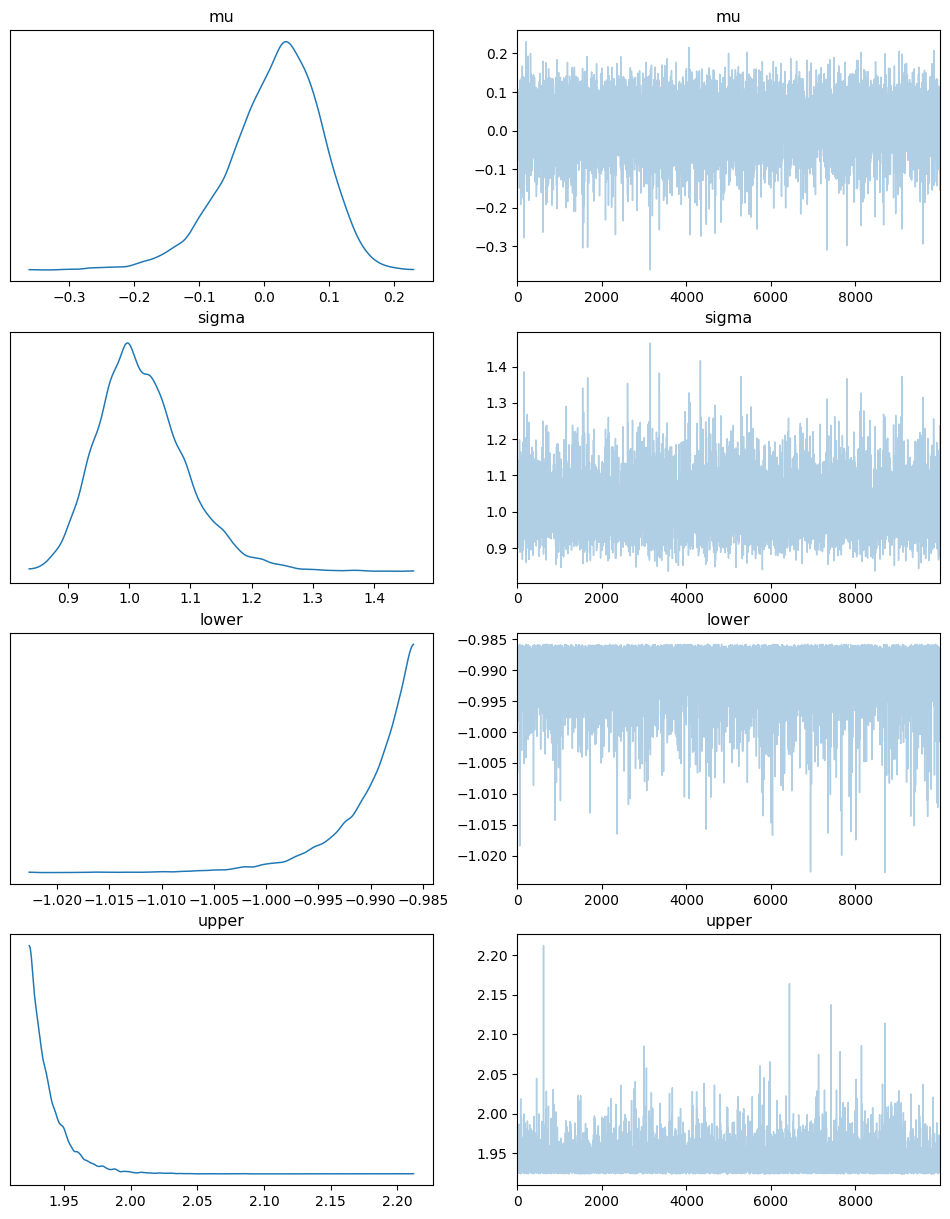

In [63]:
az.plot_trace(trace, var_names=["mu", "sigma", "lower", "upper"], figsize=(12, 15))

#### 1. Распределение lower имеет меньший разброс, чем upper, потому что исходные данные имеют гораздо более высокую плотность значений около нижней границы, чем около верхней => нижняя граница усечения определяется более точно.
#### 2. Распределение параметра mu скошено влево, потому что усечение справа сильнее влияет на оценку среднего, чем усечение слева. Распределения справа обрезано на большем расстоянии от центра, что приводит к скосу оценки среднего влево.

### Task 2

In [25]:
euro = pd.read_csv('https://stepik.org/media/attachments/lesson/1251114/euroweight.dat.txt', sep='\t', names=['weight', 'batch'], index_col=0)
euro.head()

,weight,batch
1,7.512,1
2,7.502,1
3,7.461,1
4,7.562,1
5,7.528,1


In [26]:
batch_indeces = euro['batch'].values - 1
batches_amount = len(np.unique(batch_indeces))

In [21]:
with pm.Model() as model:
    mu_b = pm.Normal('mu_b', 0, 100)
    sigma_b = pm.HalfNormal('sigma_b', 5)
    sigma = pm.HalfNormal('sigma', 10)

    mu_j = pm.Normal('mu_j', mu=mu_b, sigma=sigma_b, shape=batches_amount)

    weight = pm.Normal('weight', mu=mu_j[batch_indeces], sigma=sigma, observed=euro['weight'].values)

    trace = pm.sample(10000, chains=1, tune=1000)

Output()

In [22]:
mu_j_samples = trace.posterior['mu_j'].values[0]
mean_mu_j = mu_j_samples.mean(axis=0)

In [23]:
diff_samples = mu_j_samples[:, max_batch] - mu_j_samples[:, min_batch]
diff_hdi = az.hdi(diff_samples, hdi_prob=0.95)

In [31]:
print(f"95% доверительный интервал для mu_{max_batch+1} - μ_{min_batch+1}: {diff_hdi[0]:.8f}, {diff_hdi[1]:.8f}")
print(f"Содержит 0?: {'Нет' if (diff_hdi[0] > 0 or diff_hdi[1] < 0) else 'Да'}")

95% доверительный интервал для mu_5 - μ_3: 0.01427493, 0.02631111
Содержит 0?: Нет


### Task 3

In [32]:
data = pd.read_csv('https://stepik.org/media/attachments/lesson/832665/Fish.csv')
data = data.drop(40, axis=0)
data.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [40]:
log_weight_arr = np.log(data['Weight'])
log_length1_arr = np.log(data['Length1'])
log_height_arr = np.log(data['Height'])
log_width_arr = np.log(data['Width'])

In [41]:
with pm.Model() as model:
    beta = pm.Normal('beta', 0, 100, shape=4)
    sigma = pm.HalfNormal('sigma', 100)
    mu = beta[0] + beta[1] * log_length1_arr + beta[2] * log_height_arr + beta[3] * log_width_arr
    
    log_weight = pm.Normal('log_weight', mu=mu, sigma=sigma, observed=log_weight_arr)
    betas_sum = pm.Deterministic('betas_sum', beta[1] + beta[2] + beta[3])

    trace = pm.sample(10000, chains=1, tune=1000)

Output()

In [44]:
betas_sum_hdi = az.hdi(trace, var_names=['betas_sum'], hdi_prob=0.95)['betas_sum']
print(f"95% доверительный интервал для β1 + β2 + β3: {betas_sum_hdi[0]:.8f}, {betas_sum_hdi[1]:.8f}")

95% доверительный интервал для β1 + β2 + β3: 2.96838605 3.04491881


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

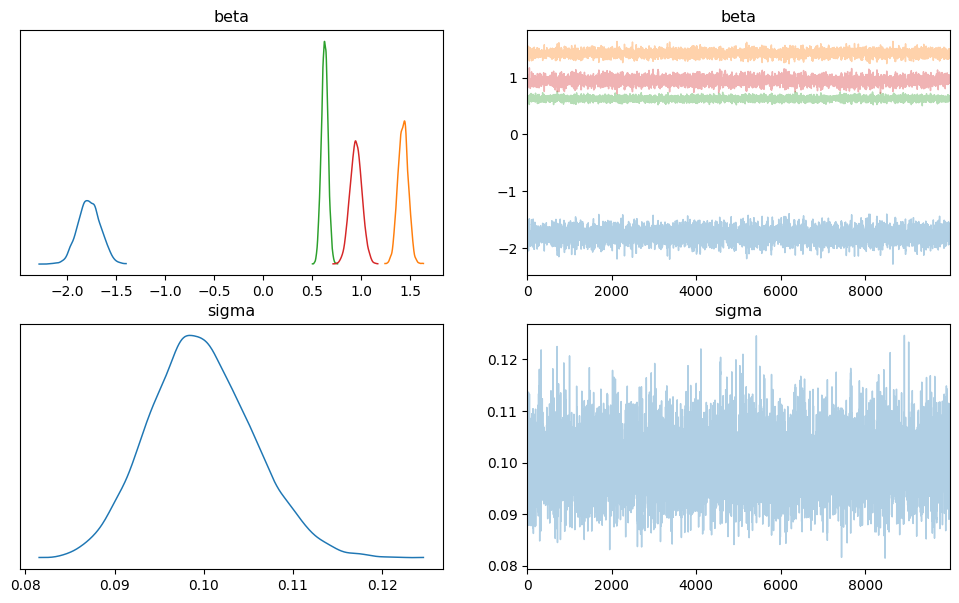

In [50]:
az.plot_trace(trace, var_names=['beta', 'sigma'], figsize=(12, 7))

### Task 4

In [66]:
def average_risk(p1: float, p2: float, mu1, cov1, mu2, cov2) -> np.float:
    samples_amount = 10000

    labels = np.random.choice([1, 2], size=samples_amount, p=[p1, p2])
    
    class1_samples = ss.multivariate_normal(mean=mu1, cov=cov1).rvs(size=np.sum(labels == 1))
    class2_samples = ss.multivariate_normal(mean=mu2, cov=cov2).rvs(size=np.sum(labels == 2))
    
    samples = np.zeros((samples_amount, 2))
    samples[labels == 1] = class1_samples
    samples[labels == 2] = class2_samples
    
    class1_pdf = ss.multivariate_normal(mean=mu1, cov=cov1).pdf(samples)
    class2_pdf = ss.multivariate_normal(mean=mu2, cov=cov2).pdf(samples)
    
    decisions = np.where((p1 * class1_pdf) > (p2 * class2_pdf), 1, 2)
    errors = (decisions != labels)
    
    return np.mean(errors)

In [67]:
average_risk(0.3, 0.7, [0, 0], [[1, 0.5], [0.5, 1]], [2.5, 0], [[1, -0.5], [-0.5, 1]])

0.0875

### Task 5

In [32]:
# анлак